In [1]:
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#pip install polars
import polars as pl
# Lee el archivo TSV
df_polar = pl.read_csv("PangenomeCountMeropenem.tsv", separator='\t')

# Muestra el DataFrame
print(df_polar.head())
#Convertir a pandas
df = df_polar.to_pandas()

shape: (5, 196_487)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ accession ┆ genus     ┆ species   ┆ phenotype ┆ … ┆ GCA_00328 ┆ GCA_00328 ┆ GCA_00328 ┆ GCA_0032 │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ 8475_CDS_ ┆ 8475_CDS_ ┆ 8475_CDS_ ┆ 88475_CD │
│ str       ┆ str       ┆ str       ┆ str       ┆   ┆ 1789      ┆ 1917      ┆ 2109      ┆ S_2205   │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ GCA_00294 ┆ Acinetoba ┆ baumannii ┆ Resistant ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ 7415      ┆ cter      ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ GCA_00294 ┆ Acinetoba ┆ baumannii ┆ Resistant ┆ … ┆ 0.0       ┆ 0.0  

In [3]:
DF_non_test= df[df["phenotype"].isin(["Resistant", "Susceptible"])]
#DF_non_test=DF_non_test.drop(columns=['measurement_value'])
DF_test= df[df["phenotype"].isna()]
#DF_test=DF_test.drop(columns=['measurement_value'])

In [4]:
DF_non_test.dtypes

accession                  object
genus                      object
species                    object
phenotype                  object
measurement_value         float64
                           ...   
GCA_003288475_CDS_1757    float64
GCA_003288475_CDS_1789    float64
GCA_003288475_CDS_1917    float64
GCA_003288475_CDS_2109    float64
GCA_003288475_CDS_2205    float64
Length: 196487, dtype: object

In [5]:
#from sklearn.linear_model import LassoCV
#from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [6]:
labels= DF_non_test.iloc[:,3]
print(labels.head())
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
encoded_labels = label_encoder.fit_transform(labels)

# Print the encoded labels
print(encoded_labels)

0    Resistant
1    Resistant
2    Resistant
3    Resistant
4    Resistant
Name: phenotype, dtype: object
[0 0 0 ... 0 0 0]


In [7]:
# División de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(
                                        DF_non_test.iloc[:, 5:],
                                        encoded_labels,
                                        train_size   = 0.7,
                                        random_state = 42,
                                        shuffle      = True
                                    )

In [8]:
modelo = Lasso(alpha=.0049137098466)
#modelo = Lasso(alpha=0.004880251583654434)

modelo.fit(X_train, y_train)

Lasso(alpha=0.0049137098466)

In [9]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
5,ERR1204815_CDS_0416,-0.005428
80,ERR1204877_CDS_0770,-0.004942
132,ERR1204991_CDS_2441,0.001037
262,ERR1228400_CDS_5262,0.004855
299,ERR1374907_CDS_4935,-0.004322
...,...,...
195685,ERR1204871_CDS_5123,-0.001079
195827,ERR1217060_CDS_1999,0.001784
195862,ERR1228345_CDS_5280,0.016574
195891,ERR1415489_CDS_3481,0.009720


Accuracy: 0.90


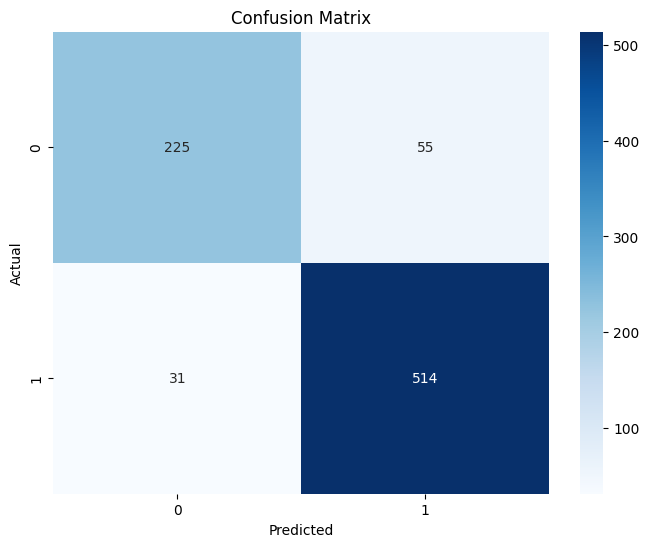

In [10]:
y_pred_continuous = modelo.predict(X_test)
from sklearn.metrics import confusion_matrix, accuracy_score

# Define a threshold to convert continuous predictions to binary classes
threshold = 0.5  # Adjust this threshold based on your specific needs

# Convert continuous predictions to binary classes
y_pred_binary = (y_pred_continuous >= threshold).astype(int)
y_test_binary = (y_test >= threshold).astype(int)  # Convert true values to binary as well

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
accuracy = accuracy_score(y_test_binary, y_pred_binary)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [11]:
y_test_pred_continuous=modelo.predict(DF_test.iloc[:,5:])

y_test_pred_binary = (y_test_pred_continuous >= threshold).astype(int)
#y_test_binary = (y_test >= threshold).astype(int)  # Convert true values to binary as well

print(y_test_pred_binary)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0
 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1]


In [16]:
Lab_predicted=[]
for i in y_test_pred_binary:
    if i==1:
        Lab_predicted.append("Susceptible")
    else:
        Lab_predicted.append("Resistant")
my_prediction_df=DF_test.iloc[:,:4]
my_prediction_df["phenotype"] = Lab_predicted

In [17]:
print(my_prediction_df)

       accession        genus     species    phenotype
2749  ERR1204815   Klebsiella  pneumoniae  Susceptible
2750  ERR1204847   Klebsiella  pneumoniae  Susceptible
2751  ERR1204852   Klebsiella  pneumoniae  Susceptible
2752  ERR1204854   Klebsiella  pneumoniae  Susceptible
2753  ERR1204855   Klebsiella  pneumoniae  Susceptible
...          ...          ...         ...          ...
3179  SRR1056175  Pseudomonas  aeruginosa  Susceptible
3180  SRR1056177  Pseudomonas  aeruginosa  Susceptible
3181  SRR1056178  Pseudomonas  aeruginosa  Susceptible
3182  SRR1056179  Pseudomonas  aeruginosa  Susceptible
3183  SRR1056180  Pseudomonas  aeruginosa  Susceptible

[435 rows x 4 columns]
